In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
sys.path.append('/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/')
#from src.utils.logger_functions import console
from src.cmos_plotter.Latency_calculator import *
from src.utils.logger_functions import console
from src.utils.metadata_functions import load_metadata_as_dataframe
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [ ]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/Nonos_synaptic_blockers'
PROCESSED_DATA_PATH = os.path.join(MAIN_PATH, f'Sorters/')
OUTPUT_PATH = os.path.join(MAIN_PATH,f'Latency_plots/Temp')
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

filename = 'ID1851_N2_DIV100_DATE20240530_1419_spontaneous_.raw.h5'

SORTER_PATH = PROCESSED_DATA_PATH
FULL_SORTER_PATH = os.path.join(SORTER_PATH,'Sorter_'+filename)
PAIRINGS_PATH = os.path.join(MAIN_PATH, f'biTE_new/')


In [ ]:
def get_electrode_unit_info_te(data, pairings, area, unit_ids):
    spikes = np.array([[int(row[0]), float(row[1]), float(row[2])] for row in data['SPIKEMAT']])
    spikes_extremum = data['SPIKEMAT_EXTREMUM']
    max_pre = 3
    electrodes_pre_all = []
    electrodes_post_all = []
    pre_extremum_all = []
    post_extremum_all = []
    unit_pre_all = []
    unit_post_all = []
    unit_indices_pre = pairings['source'].astype(int)
    unit_indices_post = pairings['target'].astype(int)
    lag_all = pairings['lag']
    for unit_pre_idx, unit_post_idx in zip(unit_indices_pre, unit_indices_post):   
    
        unit_pre = unit_ids[unit_pre_idx]
        unit_post = unit_ids[unit_post_idx]
        if unit_pre != unit_post:
            post_extremum = [int(np.unique(spikes_extremum['Electrode'][spikes_extremum['UnitIdx'] == unit_post_idx]))]
            pre_extremum = [int(np.unique(spikes_extremum['Electrode'][spikes_extremum['UnitIdx'] == unit_pre_idx]))]
            post_extremum_all.append(post_extremum)
            pre_extremum_all.append(pre_extremum)

            electrodes_pre = sorted(data['UNIT_TO_EL'][unit_pre])
            #electrodes_pre = [data['UNIT_TO_EL'][unit] for unit in unit_pre]
            #electrodes_pre = sorted([item for sublist in electrodes_pre for item in sublist])
            electrodes_pre_all.append(electrodes_pre)
            
            electrodes_post = sorted(data['UNIT_TO_EL'][unit_post])
            #electrodes_post = [data['UNIT_TO_EL'][unit] for unit in unit_post]
            #electrodes_post = sorted([item for sublist in electrodes_post for item in sublist])
            electrodes_post_all.append(electrodes_post)
            unit_pre_all.append(unit_pre)
            unit_post_all.append(unit_post)


    return spikes, electrodes_pre_all, electrodes_post_all, pre_extremum_all, post_extremum_all, unit_pre_all, unit_post_all, lag_all


In [ ]:
data = np.load(os.path.join(PROCESSED_DATA_PATH, f'{filename[:-3]}_processed.pkl'), allow_pickle=True)
spikes_extremum = pd.DataFrame(data['SPIKEMAT_EXTREMUM'])
spikes = np.array([[int(row[0]), float(row[1]), float(row[2])] for row in data['SPIKEMAT']])
a = 0
FULL_SORTER_PATH = os.path.join(SORTER_PATH,'Sorter_'+filename)
area = filename.split('_')[1]
# Open the file in binary mode
sys.modules['numpy.rec'] = np.rec
#with open(os.path.join(PAIRINGS_PATH, f'{filename[:-3]}_processed_info_metrics.pkl'), 'rb') as f:
#    data_te = np.array(pickle.load(f))
data_te = np.load(os.path.join(PAIRINGS_PATH, f'{filename[:-3]}_processed_info_metrics.pkl'), allow_pickle=True)
if 'validated_results' in data_te.keys():
    console.info(f'Pairs from {filename} were already validated')
if a ==0:
    exp_duration = data_te['EXPERIMENT_DURATION']
    te_unit_pairs = pd.DataFrame(data_te['mTE'])
    pairings = te_unit_pairs
    

    with open(os.path.join(FULL_SORTER_PATH, 'wf_folder_curated/sparsity.json'), 'r') as file:
        sorting_info = json.load(file)

    unit_ids = sorting_info['unit_ids']

    spikes, electrodes_pre_all, electrodes_post_all, pre_extremum_all, post_extremum_all, unit_pre_all, unit_post_all, lag_all = get_electrode_unit_info_te(data, pairings, area, unit_ids)

In [ ]:

def convert_elno_to_xy(elno):
    chipWidth = 220
    x = int(elno/chipWidth)
    y = elno % chipWidth
    return x,y

def get_latency_all(spikes, spikes_extremum, unit_ids, unit_pre, unit_post, input_electrode_number, output_electrode_number):
    # Filter spikes for input and output electrodes
    input_spikes = spikes_extremum[spikes_extremum['UnitIdx'] == unit_ids.index(unit_pre)].reset_index(drop=True)
    output_spikes = pd.DataFrame(spikes[spikes[:, 0] == output_electrode_number], columns=['Electrode', 'Spike_Time', 'Amplitude']).reset_index(drop=True)

    # Create a list to store latencies
    latencies = []
    input_spike_count = 0
    input_time = None
    
    # Combine all spikes and sort by time
    all_spikes = pd.concat([
        input_spikes.assign(is_input=True),
        output_spikes.assign(is_input=False)
    ]).sort_values('Spike_Time').reset_index(drop=True)
    
    for _, spike in all_spikes.iterrows():
        current_time = spike['Spike_Time']
        
        if spike['is_input']:
            # Record as input spike
            latencies.append((input_spike_count, current_time, 0, "input"))
            input_time = current_time
            input_spike_count += 1
        elif input_time is not None:  # This is an output spike and we have a previous input
            # Only record output if it's within 10ms window
            if current_time - input_time < 10:
                latencies.append((input_spike_count-1, current_time, current_time - input_time, "output"))
    
    # Convert list to structured numpy array
    if not latencies:  # If no latencies were found
        return np.array([], dtype=[('input spike', 'i4'), ('spike time', 'f8'),
                                 ('latency', 'f4'), ('category', 'U6')])
    
    return np.array(latencies, dtype=[('input spike', 'i4'), ('spike time', 'f8'),
                                    ('latency', 'f4'), ('category', 'U6')])


def get_latency_with_extremum_V2(spikes_extremum, unit_ids, unit_pre, unit_post):
    # Filter spikes for input and output electrodes
    input_spikes = spikes_extremum[spikes_extremum['UnitIdx'] == unit_ids.index(unit_pre)].reset_index(drop=True)
    output_spikes = spikes_extremum[spikes_extremum['UnitIdx'] == unit_ids.index(unit_post)].reset_index(drop=True)
    
    # Create a list to store latencies
    latencies = []
    input_spike_count = 0
    input_time = None
    
    # Combine all spikes and sort by time
    all_spikes = pd.concat([
        input_spikes.assign(is_input=True),
        output_spikes.assign(is_input=False)
    ]).sort_values('Spike_Time').reset_index(drop=True)
    
    for _, spike in all_spikes.iterrows():
        current_time = spike['Spike_Time']
        
        if spike['is_input']:
            # Record as input spike
            latencies.append((input_spike_count, current_time, 0, "input"))
            input_time = current_time
            input_spike_count += 1
        elif input_time is not None:  # This is an output spike and we have a previous input
            # Only record output if it's within 10ms window
            if current_time - input_time < 10:
                latencies.append((input_spike_count-1, current_time, current_time - input_time, "output"))
    
    # Convert list to structured numpy array
    if not latencies:  # If no latencies were found
        return np.array([], dtype=[('input spike', 'i4'), ('spike time', 'f8'),
                                 ('latency', 'f4'), ('category', 'U6')])
    
    return np.array(latencies, dtype=[('input spike', 'i4'), ('spike time', 'f8'),
                                    ('latency', 'f4'), ('category', 'U6')])



def get_latency_with_extremum_V2(spikes_extremum, unit_ids, unit_pre, unit_post):
    # Filter spikes for input and output electrodes
    input_spikes = spikes_extremum[spikes_extremum['UnitIdx'] == unit_ids.index(unit_pre)].reset_index(drop=True)
    output_spikes = spikes_extremum[spikes_extremum['UnitIdx'] == unit_ids.index(unit_post)].reset_index(drop=True)
    
    # Create a list to store latencies
    latencies = []
    input_spike_count = 0
    input_time = None
    
    # Combine all spikes and sort by time
    all_spikes = pd.concat([
        input_spikes.assign(is_input=True),
        output_spikes.assign(is_input=False)
    ]).sort_values('Spike_Time').reset_index(drop=True)
    
    for _, spike in all_spikes.iterrows():
        current_time = spike['Spike_Time']
        
        if spike['is_input']:
            # Record as input spike
            latencies.append((input_spike_count, current_time, 0, "input"))
            input_time = current_time
            input_spike_count += 1
        elif input_time is not None:  # This is an output spike and we have a previous input
            # Only record output if it's within 10ms window
            if current_time - input_time < 10:
                latencies.append((input_spike_count-1, current_time, current_time - input_time, "output"))
    
    # Convert list to structured numpy array
    if not latencies:  # If no latencies were found
        return np.array([], dtype=[('input spike', 'i4'), ('spike time', 'f8'),
                                 ('latency', 'f4'), ('category', 'U6')])
    
    return np.array(latencies, dtype=[('input spike', 'i4'), ('spike time', 'f8'),
                                    ('latency', 'f4'), ('category', 'U6')])


def plot_latency_and_location_with_extremum_both_plots(save_path, filename, lag, exp_duration, unit_to_el, input_ids, output_ids, unit_pre, unit_post, unit_ids, spikes, spikes_extremum, extremum_output=None):
    # Create color mapping for electrodes
    input_electrodes = sorted(unit_to_el[unit_pre])
    output_electrodes = sorted(unit_to_el[unit_post])   
    electrodes_pre = input_electrodes
    electrodes_post = output_electrodes
    
    colormap_pre = plt.get_cmap('Blues')
    colormap_post = plt.get_cmap('RdPu')
    num_elecs_pre = len(electrodes_pre)
    num_elecs_post = len(electrodes_post)
    colors_pre = [colormap_pre(i / num_elecs_pre) for i in range(num_elecs_pre)]
    colors_post = [colormap_post(i / num_elecs_post) for i in range(num_elecs_post)]
    
    electrode_values_pre = electrodes_pre
    electrode_values_post = electrodes_post
    color_values = []
    color_values.extend(colors_pre)
    color_values.extend(colors_post)
    elec_to_color = {'electrode': electrode_values_pre + electrode_values_post, 'color': color_values}
    
    for idx, input_id in enumerate(input_ids):
        latency_extremum = None
        input_electrode = np.array([input_id], dtype=float)
        input_color = elec_to_color['color'][elec_to_color['electrode'].index(input_id)]
        #input_spikes = spikes_extremum['Spike_Time'][spikes_extremum['UnitIdx'] == unit_ids.index(unit_pre)]
        output_electrodes_filtered = np.array(output_ids)

        # Create figure with 2 subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # First subplot - Latency plot
        ax1.set_ylabel("Experiment Time (s)")
        ax1.set_xlim((0., 10.))
        ax1.set_xlabel("Latency (ms)")
        validation = None
        
        for output_electrode in output_electrodes_filtered:
            output_color = elec_to_color['color'][elec_to_color['electrode'].index(output_electrode)]
            if output_color is not None:
                latency_all = get_latency_all(spikes, spikes_extremum, unit_ids, unit_pre, unit_post, input_id, output_electrode)
                
                latency_all = latency_all[latency_all['latency'] < 10]

                input_before = latency_all[latency_all['category'] == 'input']
                output_before = latency_all[latency_all['category'] == 'output']
                
                ax1.scatter(output_before['latency'], output_before['spike time'] / 1000, s=7, label='output', color=output_color)
                ax1.scatter(input_before['latency'], input_before['spike time'] / 1000, s=7, label='input', color=input_color)

                if extremum_output is not None:
                    latency_extremum = get_latency_with_extremum_V2(spikes_extremum, unit_ids, unit_pre, unit_post)
                    latency_extremum = latency_extremum[latency_extremum['latency'] < 10]
                    output_extremum = latency_extremum[latency_extremum['category'] == 'output']
                    ax1.scatter(output_extremum['latency'], output_extremum['spike time'] / 1000, s=10, label='output extremum', color='green')
                
                ax1.set_title(f"Source {unit_pre} to Target {unit_post}")
                handles, labels = ax1.get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                ax1.legend(by_label.values(), by_label.keys())
        
        # Second subplot - Electrode location plot
        ax2.invert_yaxis()
        for electrode in electrodes_pre:
            x, y = convert_elno_to_xy(electrode)
            ax2.scatter(y, x, color=elec_to_color['color'][elec_to_color['electrode'].index(electrode)])
        for electrode in electrodes_post:
            x, y = convert_elno_to_xy(electrode)
            ax2.scatter(y, x, color=elec_to_color['color'][elec_to_color['electrode'].index(electrode)])
        
        # Mark extremum points
        pre_extremum_electrode = int(np.unique(spikes_extremum['Electrode'][spikes_extremum['UnitIdx'] == unit_ids.index(unit_pre)]))
        post_extremum_electrode = int(np.unique(spikes_extremum['Electrode'][spikes_extremum['UnitIdx'] == unit_ids.index(unit_post)]))
        
        x, y = convert_elno_to_xy(pre_extremum_electrode)
        ax2.scatter(y, x, color='yellow', marker='x', s=100)
        
        x, y = convert_elno_to_xy(post_extremum_electrode)
        ax2.scatter(y, x, color='green', marker='x', s=100)
        
        ax2.set_xlim(0, 220)
        ax2.set_ylim(0, 120)
        ax2.set_title(f"Pair presynaptic {unit_pre} and postsynaptic {unit_post} with lag {lag}")
        
        plt.tight_layout()
        

        plt.savefig(os.path.join(save_path, f"{filename[:-3]}_pre_{unit_pre}_post_{unit_post}_lag_{lag}_combined.pdf"), format='pdf', dpi=300)
        plt.savefig(os.path.join(save_path, f"{filename[:-3]}_pre_{unit_pre}_post_{unit_post}_lag_{lag}_combined.png"), format='png')
        plt.close()

    return latency_extremum

Adding extremum electrode positions into all_combined file

In [21]:
import seaborn as sns

In [2]:
FILE_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/Files_combined'

In [5]:
extremum_data = pd.read_pickle(os.path.join(FILE_PATH, 'all_extremum_results.pkl'))
spikemat_data = pd.read_pickle(os.path.join(FILE_PATH, 'all_spikemat_results.pkl')) 

In [26]:
extremum_data

[{'filename': 'ID2184_N0_DIV19_DATE20250402_1217_spontaneous_NGN2.raw.h5',
  'chip_id': '2184',
  'area': '0',
  'div': 19,
  'electrode': '15439',
  'unit_idx': 60,
  'unit_id': 74,
  'data_type': 'SPIKEMAT_EXTREMUM',
  'firing_rate': 1.4182876650202436,
  'isi_mean': 713.3705882352941,
  'isi_median': 574.2999999999993,
  'isi_std': 545.4013584343251,
  'isi_cv': 0.7645414142788194,
  'burst_index': 1.242156692034294,
  'spike_count': 86},
 {'filename': 'ID2184_N0_DIV19_DATE20250402_1217_spontaneous_NGN2.raw.h5',
  'chip_id': '2184',
  'area': '0',
  'div': 19,
  'electrode': '11920',
  'unit_idx': 41,
  'unit_id': 52,
  'data_type': 'SPIKEMAT_EXTREMUM',
  'firing_rate': 4.474944001730967,
  'isi_mean': 224.28805147058824,
  'isi_median': 93.125,
  'isi_std': 238.73504564089228,
  'isi_cv': 1.0644126785871093,
  'burst_index': 2.4084622976707464,
  'spike_count': 273},
 {'filename': 'ID2184_N0_DIV19_DATE20250402_1217_spontaneous_NGN2.raw.h5',
  'chip_id': '2184',
  'area': '0',
  'di

In [11]:
PROCESSED_DATA_PATH =  '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/'

In [19]:
import pandas as pd
import numpy as np
import os

done = 0
failed = 0
# Load your CSV
df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH,'Files_combined/alL_combined.csv'))

# Initialize new columns with NaN
df['source_unit_x'] = np.nan
df['source_unit_y'] = np.nan
df['target_unit_x'] = np.nan
df['target_unit_y'] = np.nan

# Iterate through each row
for idx, row in df.iterrows():
    try:
        filename = row['filename']
        unit_pre = row['source_unit_id']
        unit_post = row['target_unit_id']
        
        # Load unit locations
        unit_locations = np.load(os.path.join(PROCESSED_DATA_PATH, 
                                              f'Sorters/Sorter_{filename}/wf_folder_curated/unit_locations/unit_locations.npy'))
        
        # Load unit IDs
        data = np.load(os.path.join(PROCESSED_DATA_PATH, f'Sorters/{filename[:-3]}_processed.pkl'), 
                      allow_pickle=True)
        unit_ids = list(data['UNIT_TO_EL'].keys())
        
        # Get indices
        unit_pre_idx = unit_ids.index(unit_pre)
        unit_post_idx = unit_ids.index(unit_post)
        
        # Get locations
        unit_location_pre = unit_locations[unit_pre_idx][:2]
        unit_location_post = unit_locations[unit_post_idx][:2]
        
        # Assign to dataframe
        df.at[idx, 'source_unit_x'] = unit_location_pre[0]
        df.at[idx, 'source_unit_y'] = unit_location_pre[1]
        df.at[idx, 'target_unit_x'] = unit_location_post[0]
        df.at[idx, 'target_unit_y'] = unit_location_post[1]
        
        done+=1
    except (FileNotFoundError, ValueError, KeyError, IndexError) as e:
        print(f"Error processing row {idx} (filename: {filename}): {e}")
        failed+=1
        continue
print(f"Succesfully added {done} locations, and failed {failed} rows.")
# Save the updated dataframe
if done != 0:
    df.to_csv(os.path.join(PROCESSED_DATA_PATH,'all_combined_with_locations.csv'), index=False)

Succesfully added 3338 locations, and failed 0 rows.


In [31]:
import pandas as pd
import numpy as np
import os

# Load your CSV
df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH,'Files_combined/alL_combined.csv'))

# Initialize new columns with NaN
df['source_unit_x'] = np.nan
df['source_unit_y'] = np.nan
df['target_unit_x'] = np.nan
df['target_unit_y'] = np.nan
df['mTE'] = np.nan

done = 0
failed = 0

# Iterate through each row
for idx, row in df.iterrows():
    try:
        filename = row['filename']
        unit_pre = row['source_unit_id']
        unit_post = row['target_unit_id']
        
        # Load unit locations
        unit_locations = np.load(os.path.join(PROCESSED_DATA_PATH, 
                                              f'Sorters/Sorter_{filename}/wf_folder_curated/unit_locations/unit_locations.npy'))
        
        # Load unit IDs and data
        data = np.load(os.path.join(PROCESSED_DATA_PATH, f'Sorters/{filename[:-3]}_processed.pkl'), 
                      allow_pickle=True)
        unit_ids = list(data['UNIT_TO_EL'].keys())
        
        # Get indices
        unit_pre_idx = unit_ids.index(unit_pre)
        unit_post_idx = unit_ids.index(unit_post)
        
        # Get locations
        unit_location_pre = unit_locations[unit_pre_idx][:2]
        unit_location_post = unit_locations[unit_post_idx][:2]
        
        # Assign locations to dataframe
        df.at[idx, 'source_unit_x'] = unit_location_pre[0]
        df.at[idx, 'source_unit_y'] = unit_location_pre[1]
        df.at[idx, 'target_unit_x'] = unit_location_post[0]
        df.at[idx, 'target_unit_y'] = unit_location_post[1]
        
        # Load mTE data from separate file
        data_te = np.load(os.path.join(PROCESSED_DATA_PATH, f'biTE_new/{filename[:-3]}_processed_info_metrics.pkl'), 
                         allow_pickle=True)
        
        # Get mTE value
        mask = (data_te['mTE']['target'].astype(int) == unit_post_idx) & \
               (data_te['mTE']['source'].astype(int) == unit_pre_idx)
        
        if mask.any():
            df.at[idx, 'mTE'] = data_te['mTE']['te'][mask][0]
        
        done += 1    
        
    except (FileNotFoundError, ValueError, KeyError, IndexError) as e:
        failed += 1
        print(f"Error processing row {idx} (filename: {filename}): {e}")
        continue

print(f"Successfully processed: {done}, Failed: {failed}")

# Save the updated dataframe
if done != 0:
    df.to_csv(os.path.join(PROCESSED_DATA_PATH,'all_combined_with_locations_and_mTE.csv'), index=False)

Successfully processed: 3338, Failed: 0


In [32]:
df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH,'all_combined_with_locations_and_mTE.csv'))

In [33]:
def custom_lineplot(data, x_metric, y_metric, axes, label, fontsize=16, labelsize=14, xlim = None, ylim = None, save_path=None):
    plt.rcParams['xtick.bottom'] = True    
    plt.rcParams['ytick.left'] = True    
    plt.rcParams['font.family'] = 'Arial'    
    sns.lineplot(data=data, x=x_metric, y=y_metric, color="dimgrey", markers=True, estimator="mean", 
                 err_style="bars", legend=True, zorder=1, ax=axes, dashes=False, marker="o", ms=10, linewidth=0.5, errorbar=("ci", 95))        
    axes.set_ylabel(label, fontsize=fontsize)    
    axes.set_xlabel("Day In Vitro", fontsize=fontsize)    
    axes.grid(True, linestyle=':', alpha=0.7)    
    axes.tick_params(axis='both', which='major', labelsize=labelsize, width=1.5, length=8)
    if xlim is not None:
        axes.set_xlim(xlim)
    if ylim is not None:
        axes.set_ylim(ylim)
    if save_path:
        plt.savefig(os.path.join(save_path, f'{label[:-3]}.png'), dpi=300)
        plt.savefig(os.path.join(save_path, f'{label[:-3]}.pdf'), dpi=300)

In [38]:
df['lag']

0       1.0
1       9.0
2       4.0
3       7.0
4       3.0
       ... 
3333    4.0
3334    4.0
3335    6.0
3336    3.0
3337    3.0
Name: lag, Length: 3338, dtype: float64

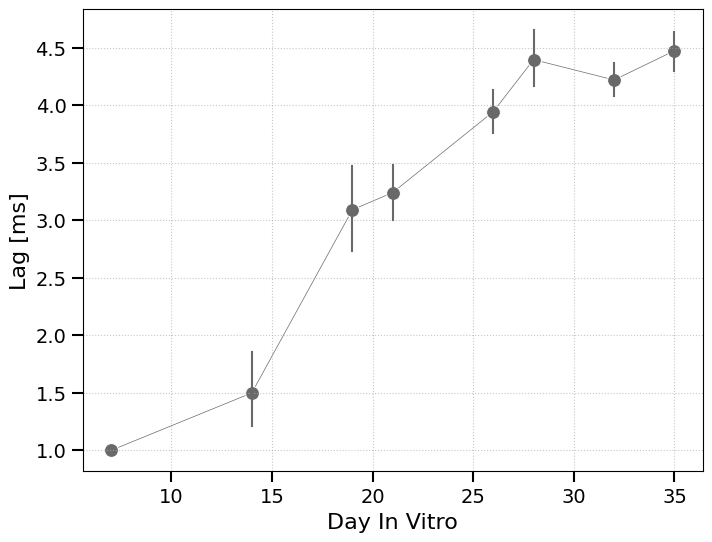

In [40]:
fig, ax = plt.subplots(figsize=(8,6))

custom_lineplot(df, df['div'], df['lag'], ax, label = 'Lag [ms]', fontsize=16, labelsize=14, xlim = None, ylim = None)      